<a href="https://colab.research.google.com/github/antbartash/australian_rain/blob/main/DEAP/PSO.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
! pip install catboost
! pip install deap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 8.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.4/135.4 kB 2.9 MB/s eta 0:00:00


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.base import clone
from catboost import CatBoostClassifier
from deap import base, creator, tools
from scipy.stats import randint, uniform, loguniform
import random
import operator
import math
import multiprocessing
import time

random.seed(42)

In [3]:
data = pd.read_csv(
    'https://raw.githubusercontent.com/antbartash/australian_rain/main/data/data_transformed.csv',
    index_col=0
)
X, y = data.drop(columns=['RainTomorrow', 'RainToday']), data['RainTomorrow']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

for column in ['Location', 'WindGustDir', 'WindDir9am', 'WindDir3pm']:
    X_train[column] = X_train[column].astype(np.float32).fillna(-1).apply(lambda x: str(x))
    X_test[column] = X_test[column].astype(np.float32).fillna(-1).apply(lambda x: str(x))

model = CatBoostClassifier(
    cat_features=['Location', 'WindGustDir', 'WindDir9am', 'WindDir3pm'],
    objective='Logloss',
    random_state=42, verbose=False, task_type='GPU'#, gpu_ram_part=0.15, used_ram_limit='2gb'
)

In [4]:
# PSO parameters
N = 15
w = 0.5 # inertia weight coefficient
c1 = 0.3 # cognitive coefficient
c2 = 0.5 # social coefficient
NUM_TRIALS = 30

creator.create('FitnessMax', base.Fitness, weights=(1.0,))
creator.create('Particle', list, fitness=creator.FitnessMax,
               speed=list, smin=list, smax=list, best=None)
toolbox = base.Toolbox()

In [5]:
# Register hyperparameters with their distributions
PARAM_NAMES = [
    'n_estimators', 'learning_rate', 'depth', 'l2_leaf_reg',
    'bagging_temperature', 'grow_policy', 'scale_pos_weight'
]
toolbox.register('n_estimators', randint.rvs, 10, 500)
toolbox.register('learning_rate', loguniform.rvs, 1e-6, 0.5)
toolbox.register('depth', randint.rvs, 1, 8)
toolbox.register('l2_leaf_reg', uniform.rvs, 0.0, 100.0)
toolbox.register('bagging_temperature', uniform.rvs, 0.0, 100.0)
toolbox.register('grow_policy', random.choice, ['SymmetricTree', 'Depthwise'])
toolbox.register('scale_pos_weight', uniform.rvs, 1.0, 4.0)

In [6]:
def generate(speed_bound):
    part = tools.initCycle(creator.Particle,
                           [toolbox.n_estimators,
                            toolbox.learning_rate,
                            toolbox.depth,
                            toolbox.l2_leaf_reg,
                            toolbox.bagging_temperature,
                            toolbox.grow_policy,
                            toolbox.scale_pos_weight])
    part.speed = [random.uniform(speed_bound[i]['smin'], speed_bound[i]['smax']) for i in range(len(part))]
    part.smin = [speed_bound[i]['smin'] for i in range(len(part))]
    part.smax = [speed_bound[i]['smax'] for i in range(len(part))]
    return part

# Define genes of partickes
toolbox.register('particle', generate,
                 speed_bound=[{'smin': -100, 'smax': 100},
                              {'smin': -0.1, 'smax': 0.1},
                              {'smin': -1, 'smax':1},
                              {'smin': -10, 'smax': 10},
                              {'smin': -10, 'smax': 10},
                              {'smin': -1, 'smax': 1},
                              {'smin': -0.5, 'smax': 0.5}])
toolbox.register('population', tools.initRepeat, list, toolbox.particle)

In [7]:
grow_policy_dict = {
    'SymmetricTree': 0,
    'Depthwise': 1,
    0: 0,
    1: 1
}

def updateParticle(part, best, c1, c2, w, is_int):
    part[5] = grow_policy_dict[part[5]]
    part.best[5] = grow_policy_dict[part.best[5]]
    best[5] = grow_policy_dict[best[5]]

    w = [w for _ in range(len(part))]
    u1 = (random.uniform(0, 1)*c1 for _ in range(len(part)))
    u2 = (random.uniform(0, 1)*c2 for _ in range(len(part)))
    v_u1 = map(operator.mul, u1, map(operator.sub, part.best, part))
    v_u2 = map(operator.mul, u2, map(operator.sub, best, part))
    part.speed = list(map(operator.add, map(operator.mul, w, part.speed), map(operator.add, v_u1, v_u2)))
    for i, speed in enumerate(part.speed):
        if abs(speed) < part.smin[i]:
            part.speed[i] = math.copysign(part.smin[i], speed)
        elif abs(speed) > part.smax[i]:
            part.speed[i] = math.copysign(part.smax[i], speed)
    part[:] = list(map(operator.add, part, part.speed))

    for i, pos in enumerate(part):
        if is_int[i]:
            part[i] = int(pos)

# # Register the update strategy
#     'n_estimators', 'learning_rate', 'depth', 'l2_leaf_reg',
#     'bagging_temperature', 'grow_policy', 'scale_pos_weight'
toolbox.register('update', updateParticle, c1=c1, c2=c2, w=w,
                 is_int=[True, False, True, False, False, True, False])

In [8]:
def evaluate(individual):
    # convert list of parameter values into dictionary of kwargs
    strategy_params = {k: v for k, v in zip(PARAM_NAMES, individual)}
    strategy_params['grow_policy'] = 'SymmetricTree' if strategy_params['grow_policy'] == 0 else 'Depthwise'
    if (strategy_params['scale_pos_weight'] < 1) or \
      (strategy_params['bagging_temperature'] < 0) or \
      (strategy_params['n_estimators'] <= 0):
      return [-np.inf]
    if strategy_params['learning_rate'] <= 0:
      strategy_params['learning_rate'] = 1e-6
    tuned_model = clone(model).set_params(**strategy_params)
    score = np.mean(cross_val_score(tuned_model, X_train, y_train, cv=3, scoring='roc_auc'))
    return score

toolbox.register('evaluate', evaluate)

In [9]:
pool = multiprocessing.Pool(1)
toolbox.register('map', pool.map)

# N = 15

In [9]:
pop = toolbox.population(n=N)
mean_arr = np.ndarray(NUM_TRIALS)
best_arr = np.ndarray(NUM_TRIALS)
hall_of_fame = tools.HallOfFame(maxsize=3)
print(f"Start time: {time.strftime('%Y-%m-%d %H:%M:%S', time.localtime())}")

best = None
for g in range(NUM_TRIALS):
    fitnesses = toolbox.map(toolbox.evaluate, pop)
    for part, fit in zip(pop, fitnesses):
        if type(fit) != list:
          fit = [fit]
        part.fitness.values = fit

        if not part.best or part.fitness.values > part.best.fitness.values:
            part.best= creator.Particle(part)
            part.best.fitness.values = part.fitness.values
        if not best or part.fitness.values > best.fitness.values:
            best = creator.Particle(part)
            best.fitness.values = part.fitness.values
    for part in pop:
        toolbox.update(part, best)

    hall_of_fame.update(pop)

    print(
      f"\nHALL OF FAME - generation {g} - {time.strftime('%Y-%m-%d %H:%M:%S', time.localtime())}:\n"
      + "\n".join(
          [
              f"    {_}: {ind}, Fitness: {ind.fitness.values[0]}"
              for _, ind in enumerate(hall_of_fame)
          ]
      )
    )

    fitnesses = [
        ind.fitness.values[0] for ind in pop if not np.isinf(ind.fitness.values[0])
    ]
    mean_arr[g] = np.mean(fitnesses)
    best_arr[g] = np.max(fitnesses)

Start time: 2024-01-04 17:15:32

HALL OF FAME - generation 0 - 2024-01-04 17:18:24:
    0: [83, 0.02619732831621637, 3, 77.08106912841497, 8.247458405286087, 1, 2.876047111541371], Fitness: 0.83868336443473
    1: [226, 0.0342936475731684, 2, 76.60363334293042, 2.529580292707432, 0, 1.348027848794583], Fitness: 0.8179234398739145
    2: [8, -0.022481937157563532, 2, 54.76952482495374, 3.4141278064376195, 0, 4.395165184786206], Fitness: 0.7976350241997056

HALL OF FAME - generation 1 - 2024-01-04 17:21:04:
    0: [232, 0.05143346199071805, 2, 75.59592187308584, 0.18550532652005458, 0, 1.3955190847739527], Fitness: 0.861964491171222
    1: [108, 0.04269277060340142, 2, 75.08581643487632, 7.544455555373418, 0, 2.376047111541371], Fitness: 0.8491411690986546
    2: [200, 0.023788778748619177, 2, 74.12681899983187, 17.46344540814114, 0, 3.4421776809773945], Fitness: 0.8403597894269357

HALL OF FAME - generation 2 - 2024-01-04 17:23:29:
    0: [235, 0.060003369199492874, 2, 75.09206613816355

In [10]:
params = {}
for idx_hof, param_name in enumerate(PARAM_NAMES):
    if param_name == 'grow_policy':
        params[param_name] = 'SymmetricTree' if hall_of_fame[0][idx_hof] == 0 else 'Depthwise'
    else:
      params[param_name] = hall_of_fame[0][idx_hof]

params

{'n_estimators': 266,
 'learning_rate': 0.06421782433328285,
 'depth': 2,
 'l2_leaf_reg': 80.44678954064292,
 'bagging_temperature': 0.06693547098844227,
 'grow_policy': 'SymmetricTree',
 'scale_pos_weight': 1.924207424961724}

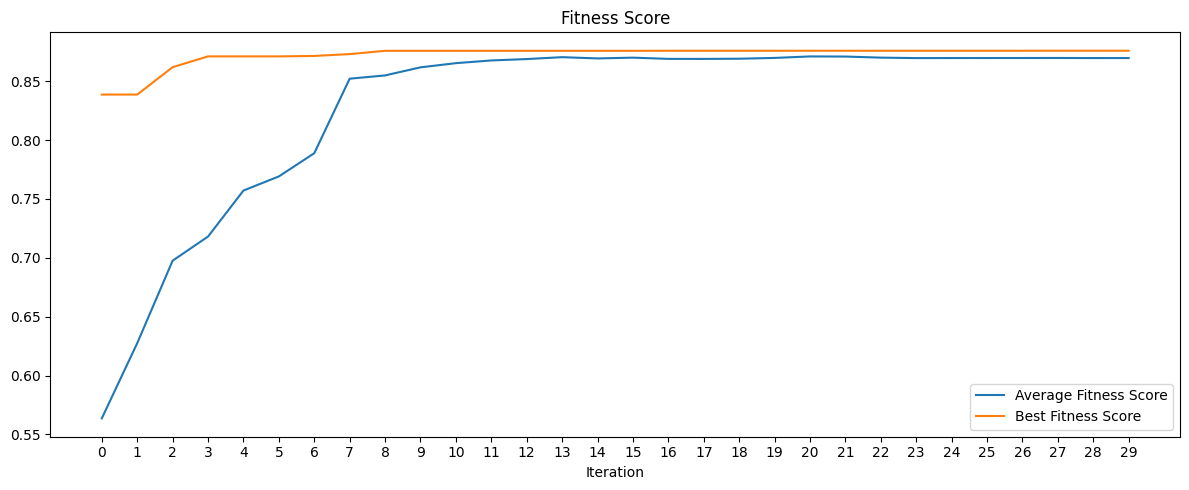

In [19]:
# correction
best_arr[1:] = [np.max(best_arr[:x]) for x in range(1, len(best_arr))]

fig, ax = plt.subplots(sharex=True, figsize=(12, 5))
sns.lineplot(x=range(NUM_TRIALS), y=mean_arr, ax=ax, label='Average Fitness Score')
sns.lineplot(x=range(NUM_TRIALS), y=best_arr, ax=ax, label='Best Fitness Score')
ax.set_title('Fitness Score')
ax.set_xticks(range(NUM_TRIALS))
ax.set_xlabel('Iteration')
plt.tight_layout()
plt.show()

# N = 30

In [ ]:
N = 30

pop = toolbox.population(n=N)
mean_arr = np.ndarray(NUM_TRIALS)
best_arr = np.ndarray(NUM_TRIALS)
hall_of_fame = tools.HallOfFame(maxsize=3)
print(f"Start time: {time.strftime('%Y-%m-%d %H:%M:%S', time.localtime())}")

best = None
for g in range(NUM_TRIALS):
    fitnesses = toolbox.map(toolbox.evaluate, pop)
    for part, fit in zip(pop, fitnesses):
        if type(fit) != list:
          fit = [fit]
        part.fitness.values = fit

        if not part.best or part.fitness.values > part.best.fitness.values:
            part.best= creator.Particle(part)
            part.best.fitness.values = part.fitness.values
        if not best or part.fitness.values > best.fitness.values:
            best = creator.Particle(part)
            best.fitness.values = part.fitness.values
    for part in pop:
        toolbox.update(part, best)

    hall_of_fame.update(pop)

    print(
      f"\nHALL OF FAME - generation {g} - {time.strftime('%Y-%m-%d %H:%M:%S', time.localtime())}:\n"
      + "\n".join(
          [
              f"    {_}: {ind}, Fitness: {ind.fitness.values[0]}"
              for _, ind in enumerate(hall_of_fame)
          ]
      )
    )

    fitnesses = [
        ind.fitness.values[0] for ind in pop if not np.isinf(ind.fitness.values[0])
    ]
    mean_arr[g] = np.mean(fitnesses)
    best_arr[g] = np.max(fitnesses)

Start time: 2024-01-04 20:05:06

HALL OF FAME - generation 0 - 2024-01-04 20:11:40:
    0: [400, -0.013915232461562385, 3, 52.64353126580368, 3.375645088363834, 0, 1.7383380227592204], Fitness: 0.8722995323859792
    1: [392, 0.00647836217985541, 2, 22.109884753956468, 19.745635465255617, 0, 3.342750817366558], Fitness: 0.8449836418564605
    2: [469, 0.011190713512076738, 3, 29.063022196504146, 3.9154549367542844, 0, 1.7986612566511173], Fitness: 0.840602654893542

HALL OF FAME - generation 1 - 2024-01-04 20:19:12:
    0: [411, 0.23808058924399705, 5, 25.693059712609863, 21.121786820611604, 0, 1.9331160988474945], Fitness: 0.8815076919784924
    1: [400, -0.013915232461562385, 3, 52.64353126580368, 3.375645088363834, 0, 1.7383380227592204], Fitness: 0.8722995323859792
    2: [465, 0.11119071351207674, 3, 32.24017464856536, 10.509407831771263, 0, 1.8362085440065878], Fitness: 0.8601842710074683

HALL OF FAME - generation 2 - 2024-01-04 20:27:51:
    0: [429, 0.21308058924399706, 4, 27.